In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from scipy.optimize import fmin_bfgs, check_grad
import glob, os

os.chdir('../core')
import stitching_ssid as ssid
os.chdir('../dev')

import pprint

# Covariance matrix completion 
- $\mbox{cov}(y) = C C^\top$
- if cov($y$) has missing off-diagonal blocks, parts of $C$ are underdetermined (change of latent basis)
- Bishop et al. (2014) introduced a basic algorithm for rotating latent bases based on overlap
- Srini had the idea to just learn all chunks of C at the same time using gradient descent

In [ ]:

p,n = 20,4
k,l = 1,1
overlap_size = 4

# create subpopulations
sub_pops = (np.arange(0,12), np.arange(8,p))
print('sub_pops', sub_pops)

obs_idx, idx_grp = ssid.get_obs_index_groups(obs_scheme={'sub_pops': sub_pops,'obs_pops': (0,1)},p=p)
overlaps, overlap_grp, idx_overlap = ssid.get_obs_index_overlaps(idx_grp, sub_pops)
print('idx_grp:', idx_grp)
print('obs_idx:', obs_idx)
        
Om, Ovw, Ovc = ssid.comp_subpop_index_mats(sub_pops,idx_grp,overlap_grp,idx_overlap)    
    
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(Om,interpolation='none')
plt.title('Observation pattern')
plt.subplot(1,3,2)
plt.imshow(Ovw,interpolation='none')
plt.title('Overlap pattern')
plt.subplot(1,3,3)
plt.imshow(Ovc,interpolation='none')
plt.title('Cross-overlap pattern')
plt.show()

for rep in range(10):
    
    C_true = np.random.normal(size=(p,n))
    Q_true = C_true.dot(C_true.T)
    Q_obs = Q_true * np.asarray( Om, dtype=float)
    Q_sti = Q_true * np.asarray(~Om, dtype=float)
    A, Pi = np.eye(n), np.eye(n)
    
    C_0 = np.random.normal(size=(p,n))
        
    def f_i(C):        
        return ssid.f_l2_Hankel(C,A,Pi,k,l,[Q_obs], Om)*np.sum(Om)
    def g_i(C):
        return ssid.g_C_l2_Hankel(C,A,Pi,k,l,[Q_obs],idx_grp, obs_idx)
    
    
    
    print('difference in gradient to finite-differencing value:', check_grad(f_i, g_i, C_0.reshape(p*n,)))
    
    C_est = fmin_bfgs(f_i, C_0.reshape(p*n,), fprime=g_i, gtol=1e-20).reshape(p,n)
    

    print('final squared error on observed parts:', 
          ssid.f_l2_block(C_est, A, Q_obs, Om))
    print('final squared error on overlapping parts:', 
          ssid.f_l2_block(C_est, A, Q_obs, Ovw))
    print('final squared error on cross-overlapping parts:',
          ssid.f_l2_block(C_est, A, Q_obs, Ovc))
    print('final squared error on stitched parts:',
          ssid.f_l2_block(C_est, A, Q_sti,~Om))

    plt.figure(figsize=(18,12))
    plt.subplot(2,2,1)
    plt.imshow(C_0.dot(C_0.T),interpolation='none')
    plt.title('Initial matrix (C_0 C_0^T)')
    plt.subplot(2,2,3)
    plt.imshow(Q_true,interpolation='none')
    plt.title('True  matrix')
    plt.subplot(2,2,4)
    plt.imshow(C_est.dot(C_est.T),interpolation='none')
    plt.title('Estimated matrix')
    plt.subplot(2,2,2)
    plt.imshow(Q_true[Ovw].reshape(-1,overlap_size), interpolation='none')
    plt.title('overlaps (extracted)')
    plt.show()

    #_,s,_ = np.linalg.svd(Q_true[Ovw].reshape(-1,2)[:2,:])
    #print('singular values first overlap:', s)
    #_,s,_ = np.linalg.svd(Q_true[Ovw].reshape(-1,2)[2:,:])
    #print('singular values second overlap:', s)
    
    print('\n')
    print('\n')


# Hankel covariance matrix completion 
- $ H_{k,l} = (I_k \otimes C) H^{xx}_{k,l} (I_l \otimes C)^\top $
- $ H^{xx}_{k,l} = \left[\begin{array}{llll} A \Pi & A^2 \Pi & \ldots & A^l \Pi\\ A^2 \Pi & A^3 \Pi & \ldots & A^{l+1} \Pi\\ \vdots & \vdots & \ddots & \vdots \\ A^{k} \Pi & A^{k+1} \Pi & \ldots & A^{k+l-1} \Pi \end{array} \right] $
- if cov($x$) has missing off-diagonal blocks, parts of $C$ are underdetermined (change of latent basis)
- each block of the Hankel cov matrix $H_{k,l}$ exhibits the same structure of missing entries as does cov($y$.
- We can combine the overlaps of the $k \times l$ many blocks of $H_{k,l}$ when collecting constraints on the latent basis.
- We here first assume $A,\Pi$ to be known, and apply Srini's idea of joint gradient descent on the whole $C$ to $H_{k,l}$. Then we learn $A, \Pi$ with the other parameters fixed

# Derivative w.r.t. $C$
- needs code base from commit a00b35e to run, as I later changed the function signatures

In [ ]:
p,n = 11,2
k,l = 3,3

# create subpopulations
sub_pops = (np.arange(0,6), np.arange(5,p))
print('sub_pops', sub_pops)

obs_idx, idx_grp = ssid.get_obs_index_groups(obs_scheme={'sub_pops': sub_pops,'obs_pops': (0,1)},p=p)
overlaps, overlap_grp, idx_overlap = ssid.get_obs_index_overlaps(idx_grp, sub_pops)
print('idx_grp:', idx_grp)
print('obs_idx:', obs_idx)
        
Om, Ovw, Ovc = ssid.comp_subpop_index_mats(sub_pops,idx_grp,overlap_grp,idx_overlap)    
    
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(Om,interpolation='none')
plt.title('Observation pattern')
plt.subplot(1,3,2)
plt.imshow(Ovw,interpolation='none')
plt.title('Overlap pattern')
plt.subplot(1,3,3)
plt.imshow(Ovc,interpolation='none')
plt.title('Cross-overlap pattern')
plt.show()

for rep in range(10):
    
    C_true = np.random.normal(size=(p,n))
    Pi     = np.random.normal(size=(n,n))/np.sqrt(n)
    Pi     = Pi.dot(Pi.T) #np.eye(n) 
    A      = np.random.normal(size=(n,n))    
    Qs = []
    for kl_ in range(1,k+l):
        Akl = np.linalg.matrix_power(A, kl_)
        Qs.append(C_true.dot(Akl.dot(Pi)).dot(C_true.T) *np.asarray( Om,dtype=int) )
    Qs_full = []
    for kl_ in range(1,k+l):
        Akl = np.linalg.matrix_power(A, kl_)
        Qs_full.append(C_true.dot(Akl.dot(Pi)).dot(C_true.T) )       
    H_true = ssid.yy_Hankel_cov_mat(C_true,A,Pi,k,l)
    H_obs = ssid.yy_Hankel_cov_mat(C_true,A,Pi,k,l, Om)
    H_obs[np.where(H_obs==0)] = np.nan
    H_sti = ssid.yy_Hankel_cov_mat(C_true,A,Pi,k,l,~Om)
    
    C_0 = np.random.normal(size=(p,n))
        
    def f_i(C):        
        return ssid.f_l2_Hankel(C,A,Pi,k,l,Qs, Om)*np.sum(Om)*(k*l)
    def g_i(C):
        return ssid.g_C_l2_Hankel(C,A,Pi,k,l,Qs,idx_grp, obs_idx)
    
    
    print('difference in gradient to finite-differencing value:', check_grad(f_i, g_i, C_0.reshape(p*n,)))
    
    C_est = fmin_bfgs(f_i, C_0.reshape(p*n,), fprime=g_i, gtol=1e-20).reshape(p,n)    

    print('final squared error on observed parts:', 
          ssid.f_l2_Hankel(C_est,A,Pi,k,l,Qs, Om))
    print('final squared error on overlapping parts:', 
          ssid.f_l2_Hankel(C_est,A,Pi,k,l,Qs,Ovw))
    print('final squared error on cross-overlapping parts:',
          ssid.f_l2_Hankel(C_est,A,Pi,k,l,Qs,Ovc))
    print('final squared error on stitched parts:',
          ssid.f_l2_Hankel(C_est,A,Pi,k,l,Qs_full,~Om))
    
    plt.figure(figsize=(16,12))
    plt.subplot(2,2,1)
    tmp = ssid.yy_Hankel_cov_mat(C_true,A,Pi,k,l,Om)
    tmp[np.where(tmp==0)] = np.nan
    plt.imshow(tmp,interpolation='none')
    plt.title('Given data matrix (C_true, masked)')
    plt.subplot(2,2,2)
    plt.imshow(ssid.yy_Hankel_cov_mat(C_true,A,Pi,k,l),interpolation='none')
    plt.title('True  matrix (C_true)')    
    plt.subplot(2,2,3)
    plt.imshow(ssid.yy_Hankel_cov_mat(C_0,A,Pi,k,l),interpolation='none')
    plt.title('Initial matrix (C_0)')
    plt.subplot(2,2,4)
    plt.imshow(ssid.yy_Hankel_cov_mat(C_est,A,Pi,k,l),interpolation='none')
    plt.title('Estimated matrix (C_est)')
    plt.show()
    
    # closely compare stitched blocks:
    """
    plt.figure(figsize=(20,6))
    plt.subplot(1,3,1)
    tmpt = ssid.yy_Hankel_cov_mat(C_true,A,Pi,k,l,~Om)
    tmpt = tmpt[np.where(tmpt != 0)].reshape(k*6,l*3)
    plt.imshow(tmpt,interpolation='none')
    plt.title('est. stitched Hankel subblocks (assembled)')

    plt.subplot(1,3,2)
    tmpe = ssid.yy_Hankel_cov_mat(C_est, A,Pi,k,l,~Om)
    tmpe = tmpe[np.where(tmpe != 0)].reshape(k*6,l*3)
    plt.imshow(tmpe,interpolation='none')
    plt.title('true stitched Hankel subblocks (assembled)')
    
    plt.subplot(1,3,3)
    plt.plot(tmpt, tmpe, 'r.')
    plt.xlabel('true')
    plt.ylabel('est')

    plt.show()    
    """

    #if np.sum(Ovw) > 0:
    #    _,s,_ = np.linalg.svd(Qs[0][Ovw].reshape(-1,1)[:2,:])
    #    print('singular values first overlap:', s)
    #    #_,s,_ = np.linalg.svd(Q_obs[Ovw].reshape(-1,2)[2:,:])
    #    #print('singular values second overlap:', s)    
    

# Derivative w.r.t. $\Pi$
- needs code base from commit a00b35e to run, as I later changed the function signatures

In [ ]:
p,n = 10,4
k,l = 2,2

# create subpopulations
sub_pops = (np.arange(0,p//2), np.arange(p//2,p))
print('sub_pops', sub_pops)

obs_idx, idx_grp = ssid.get_obs_index_groups(obs_scheme={'sub_pops': sub_pops,'obs_pops': (0,1)},p=p)
overlaps, overlap_grp, idx_overlap = ssid.get_obs_index_overlaps(idx_grp, sub_pops)
print('idx_grp:', idx_grp)
print('obs_idx:', obs_idx)
        
Om, Ovw, Ovc = ssid.comp_subpop_index_mats(sub_pops,idx_grp,overlap_grp,idx_overlap)    
    
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(Om,interpolation='none')
plt.title('Observation pattern')
plt.subplot(1,3,2)
plt.imshow(Ovw,interpolation='none')
plt.title('Overlap pattern')
plt.subplot(1,3,3)
plt.imshow(Ovc,interpolation='none')
plt.title('Cross-overlap pattern')
plt.show()

for rep in range(5):
    
    C      = np.random.normal(size=(p,n))
    B_true = np.random.normal(size=(n,n))/np.sqrt(n)
    Pi_true = B_true.dot(B_true.T) #np.eye(n) 
    A      = np.random.normal(size=(n,n)) # np.diag(np.linspace(0.5, 0.9, n)) #
    Qs = []
    for kl_ in range(1,k+l):
        Akl = np.linalg.matrix_power(A, kl_)
        Qs.append(C.dot(Akl.dot(Pi_true)).dot(C.T) *np.asarray( Om,dtype=int) )
    Qs_full = []
    for kl_ in range(1,k+l):
        Akl = np.linalg.matrix_power(A, kl_)
        Qs_full.append(C.dot(Akl.dot(Pi_true)).dot(C.T) )       
    H_true = ssid.yy_Hankel_cov_mat(C,A,Pi_true,k,l)
    H_obs = ssid.yy_Hankel_cov_mat(C,A,Pi_true,k,l, Om)
    H_obs[np.where(H_obs==0)] = np.nan
    H_sti = ssid.yy_Hankel_cov_mat(C,A,Pi_true,k,l,~Om)
    
    B_0  = np.random.normal(size=(n,n))
    Pi_0 = B_0.dot(B_0.T)
    
    def f_i(B):        
        if len(B.shape)<2:
            B = B.reshape(A.shape[0], A.shape[0])
        return ssid.f_l2_Hankel(C,A,B.dot(B.T),k,l,Qs, Om)*np.sum(Om)*(k*l)
    def g_i(B):
        return ssid.g_B_l2_Hankel(C,A,B,k,l,Qs,Om)
    
    
    print('difference in gradient to finite-differencing value:', check_grad(f_i, g_i, B_0.reshape(n*n,)))
    
    B_est = fmin_bfgs(f_i, B_0.reshape(n*n,), fprime=g_i, gtol=1e-20).reshape(n,n)    
    Pi_est = B_est.dot(B_est.T)
    
    print('final squared error on observed parts:', 
          ssid.f_l2_Hankel(C,A,Pi_est,k,l,Qs, Om))
    print('final squared error on overlapping parts:', 
          ssid.f_l2_Hankel(C,A,Pi_est,k,l,Qs,Ovw))
    print('final squared error on cross-overlapping parts:',
          ssid.f_l2_Hankel(C,A,Pi_est,k,l,Qs,Ovc))
    print('final squared error on stitched parts:',
          ssid.f_l2_Hankel(C,A,Pi_est,k,l,Qs_full,~Om))
    
    plt.figure(figsize=(16,12))
    plt.subplot(2,2,1)
    tmp = ssid.yy_Hankel_cov_mat(C,A,Pi_true,k,l,Om)
    tmp[np.where(tmp==0)] = np.nan
    plt.imshow(tmp,interpolation='none')
    plt.title('Given data matrix (Pi_true, masked)')
    plt.subplot(2,2,2)
    plt.imshow(ssid.yy_Hankel_cov_mat(C,A,Pi_true,k,l),interpolation='none')
    plt.title('True  matrix (Pi_true)')    
    plt.subplot(2,2,3)
    plt.imshow(ssid.yy_Hankel_cov_mat(C,A,Pi_0,k,l),interpolation='none')
    plt.title('Initial matrix (Pi_0)')
    plt.subplot(2,2,4)
    plt.imshow(ssid.yy_Hankel_cov_mat(C,A,Pi_est,k,l),interpolation='none')
    plt.title('Estimated matrix (Pi_est)')
    plt.show()
    
    plt.figure(figsize=(16,12))
    plt.subplot(1,3,1)
    plt.imshow(Pi_0,interpolation='none')
    plt.title('Pi init')
    plt.subplot(1,3,2)
    plt.imshow(Pi_est,interpolation='none')
    plt.title('Pi est')
    plt.subplot(1,3,3)
    plt.imshow(Pi_true,interpolation='none')
    plt.title('Pi true')
    plt.show()


# Derivative w.r.t. $A$

- This one is nasty: we need the derivative of $A^m$ w.r.t. $A$, i.e. $\frac{\delta{}A^m}{\delta{}A} \in \mathbb{R}^{n \times n \times n \times n}$
- needs code base from commit a00b35e to run, as I later changed the function signatures

In [ ]:
p,n = 5,3
k,l = 2,2

# create subpopulations
sub_pops = (np.arange(0,p//2), np.arange(p//2,p))
print('sub_pops', sub_pops)

obs_idx, idx_grp = ssid.get_obs_index_groups(obs_scheme={'sub_pops': sub_pops,'obs_pops': (0,1)},p=p)
overlaps, overlap_grp, idx_overlap = ssid.get_obs_index_overlaps(idx_grp, sub_pops)
print('idx_grp:', idx_grp)
print('obs_idx:', obs_idx)
        
Om, Ovw, Ovc = ssid.comp_subpop_index_mats(sub_pops,idx_grp,overlap_grp,idx_overlap)    
    
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(Om,interpolation='none')
plt.title('Observation pattern')
plt.subplot(1,3,2)
plt.imshow(Ovw,interpolation='none')
plt.title('Overlap pattern')
plt.subplot(1,3,3)
plt.imshow(Ovc,interpolation='none')
plt.title('Cross-overlap pattern')
plt.show()

for rep in range(3):
    
    C      = np.random.normal(size=(p,n))
    B      = np.random.normal(size=(n,n))/np.sqrt(n)
    Pi     = B.dot(B.T) #np.eye(n) 
    A_true = np.random.normal(size=(n,n)) # np.diag(np.linspace(0.5, 0.9, n)) #
    Qs = []
    for kl_ in range(1,k+l):
        Akl = np.linalg.matrix_power(A_true, kl_)
        Qs.append(C.dot(Akl.dot(Pi)).dot(C.T) *np.asarray( Om,dtype=int) )
    Qs_full = []
    for kl_ in range(1,k+l):
        Akl = np.linalg.matrix_power(A_true, kl_)
        Qs_full.append(C.dot(Akl.dot(Pi)).dot(C.T) )       
    H_true = ssid.yy_Hankel_cov_mat(C,A_true,Pi,k,l)
    H_obs = ssid.yy_Hankel_cov_mat( C,A_true,Pi,k,l, Om)
    H_obs[np.where(H_obs==0)] = np.nan
    H_sti = ssid.yy_Hankel_cov_mat( C,A_true,Pi,k,l,~Om)
    
    A_0  = np.random.normal(size=(n,n))
    
    def f_i(A):        
        if len(A.shape)<2:
            A = A.reshape(Pi.shape[0], Pi.shape[0])
        return ssid.f_l2_Hankel(C,A,Pi,k,l,Qs, Om)*np.sum(Om)*(k*l)
    def g_i(A):
        return ssid.g_A_l2_Hankel(C,A,Pi,k,l,Qs,Om)
    
    
    print('difference in gradient to finite-differencing value:', check_grad(f_i, g_i, A_0.reshape(n*n,)))
    
    A_est = fmin_bfgs(f_i, A_0.reshape(n*n,), fprime=g_i, gtol=1e-20).reshape(n,n)    
    
    print('final squared error on observed parts:', 
          ssid.f_l2_Hankel(C,A_est,Pi,k,l,Qs, Om))
    print('final squared error on overlapping parts:', 
          ssid.f_l2_Hankel(C,A_est,Pi,k,l,Qs,Ovw))
    print('final squared error on cross-overlapping parts:',
          ssid.f_l2_Hankel(C,A_est,Pi,k,l,Qs,Ovc))
    print('final squared error on stitched parts:',
          ssid.f_l2_Hankel(C,A_est,Pi,k,l,Qs_full,~Om))
    
    plt.figure(figsize=(16,12))
    plt.subplot(2,2,1)
    tmp = ssid.yy_Hankel_cov_mat(C,A_true,Pi,k,l,Om)
    tmp[np.where(tmp==0)] = np.nan
    plt.imshow(tmp,interpolation='none')
    plt.title('Given data matrix (A_true, masked)')
    plt.subplot(2,2,2)
    plt.imshow(ssid.yy_Hankel_cov_mat(C,A_true,Pi,k,l),interpolation='none')
    plt.title('True  matrix (A_true)')    
    plt.subplot(2,2,3)
    plt.imshow(ssid.yy_Hankel_cov_mat(C,A_0,Pi,k,l),interpolation='none')
    plt.title('Initial matrix (A_0)')
    plt.subplot(2,2,4)
    plt.imshow(ssid.yy_Hankel_cov_mat(C,A_est,Pi,k,l),interpolation='none')
    plt.title('Estimated matrix (A_est)')
    plt.show()
    
    plt.figure(figsize=(16,12))
    plt.subplot(1,3,1)
    plt.imshow(A_0,interpolation='none')
    plt.title('A init')
    plt.subplot(1,3,2)
    plt.imshow(A_est,interpolation='none')
    plt.title('A est')
    plt.subplot(1,3,3)
    plt.imshow(A_true,interpolation='none')
    plt.title('A true')
    plt.show()
    

# Derivative w.r.t. $A$, setting $\Pi = \Pi(A)$

- This one is nasty: we need the derivative of $A^m$ w.r.t. $A$, i.e. $\frac{\delta{}A^m}{\delta{}A} \in \mathbb{R}^{n \times n \times n \times n}$
- needs code base from commit a00b35e to run, as I later changed the function signatures

In [ ]:
p,n = 5,3
k,l = 2,2

# create subpopulations
sub_pops = (np.arange(0,p//2), np.arange(p//2,p))
print('sub_pops', sub_pops)

obs_idx, idx_grp = ssid.get_obs_index_groups(obs_scheme={'sub_pops': sub_pops,'obs_pops': (0,1)},p=p)
overlaps, overlap_grp, idx_overlap = ssid.get_obs_index_overlaps(idx_grp, sub_pops)
print('idx_grp:', idx_grp)
print('obs_idx:', obs_idx)
        
Om, Ovw, Ovc = ssid.comp_subpop_index_mats(sub_pops,idx_grp,overlap_grp,idx_overlap)    
    
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(Om,interpolation='none')
plt.title('Observation pattern')
plt.subplot(1,3,2)
plt.imshow(Ovw,interpolation='none')
plt.title('Overlap pattern')
plt.subplot(1,3,3)
plt.imshow(Ovc,interpolation='none')
plt.title('Cross-overlap pattern')
plt.show()

Qvec = np.eye(n).ravel()

for rep in range(3):
    
    C      = np.random.normal(size=(p,n))
    B      = np.random.normal(size=(n,n))/np.sqrt(n)
    Pi     = B.dot(B.T) #np.eye(n) 
    A_true = np.random.normal(size=(n,n)) # np.diag(np.linspace(0.5, 0.9, n)) #
    Qs = []
    for kl_ in range(1,k+l):
        Akl = np.linalg.matrix_power(A_true, kl_)
        Qs.append(C.dot(Akl.dot(Pi)).dot(C.T) *np.asarray( Om,dtype=int) )
    Qs_full = []
    for kl_ in range(1,k+l):
        Akl = np.linalg.matrix_power(A_true, kl_)
        Qs_full.append(C.dot(Akl.dot(Pi)).dot(C.T) )       
    H_true = ssid.yy_Hankel_cov_mat(C,A_true,Pi,k,l)
    H_obs = ssid.yy_Hankel_cov_mat( C,A_true,Pi,k,l, Om)
    H_obs[np.where(H_obs==0)] = np.nan
    H_sti = ssid.yy_Hankel_cov_mat( C,A_true,Pi,k,l,~Om)
    
    A_0  = np.random.normal(size=(n,n))
    
    def f_i(A):        
        if len(A.shape)<2:
            A = A.reshape(Pi.shape[0], Pi.shape[0])
            Pi = np.linalg.solve(np.eye(n*n) - np.kron(A,A), Qvec)
        return ssid.f_l2_Hankel(C,A,Pi,k,l,Qs, Om)*np.sum(Om)*(k*l)
    def g_i(A):
        
        Ams = [np.eye(n)]
        for m in range(1,k+l):
            Ams.append(A.dot(Ams[-1]))
        
        dA = np.zeros((n,n))
        for k in range(n):
            for l in range(n):
                Jkl = np.zeros((n,n))
                Jkl[k,l] = 1
                
                
        
        Qvec.T.dot(M).dot(cjci.T)
        
        #return ssid.g_A_l2_Hankel(C,A,Pi,k,l,Qs,Om)
    
    
    #print('difference in gradient to finite-differencing value:', check_grad(f_i, g_i, A_0.reshape(n*n,)))
    
    A_est = fmin_bfgs(f_i, A_0.reshape(n*n,), fprime=g_i, gtol=1e-20).reshape(n,n)    
    
    print('final squared error on observed parts:', 
          ssid.f_l2_Hankel(C,A_est,Pi,k,l,Qs, Om))
    print('final squared error on overlapping parts:', 
          ssid.f_l2_Hankel(C,A_est,Pi,k,l,Qs,Ovw))
    print('final squared error on cross-overlapping parts:',
          ssid.f_l2_Hankel(C,A_est,Pi,k,l,Qs,Ovc))
    print('final squared error on stitched parts:',
          ssid.f_l2_Hankel(C,A_est,Pi,k,l,Qs_full,~Om))
    
    plt.figure(figsize=(16,12))
    plt.subplot(2,2,1)
    tmp = ssid.yy_Hankel_cov_mat(C,A_true,Pi,k,l,Om)
    tmp[np.where(tmp==0)] = np.nan
    plt.imshow(tmp,interpolation='none')
    plt.title('Given data matrix (A_true, masked)')
    plt.subplot(2,2,2)
    plt.imshow(ssid.yy_Hankel_cov_mat(C,A_true,Pi,k,l),interpolation='none')
    plt.title('True  matrix (A_true)')    
    plt.subplot(2,2,3)
    plt.imshow(ssid.yy_Hankel_cov_mat(C,A_0,Pi,k,l),interpolation='none')
    plt.title('Initial matrix (A_0)')
    plt.subplot(2,2,4)
    plt.imshow(ssid.yy_Hankel_cov_mat(C,A_est,Pi,k,l),interpolation='none')
    plt.title('Estimated matrix (A_est)')
    plt.show()
    
    plt.figure(figsize=(16,12))
    plt.subplot(1,3,1)
    plt.imshow(A_0,interpolation='none')
    plt.title('A init')
    plt.subplot(1,3,2)
    plt.imshow(A_est,interpolation='none')
    plt.title('A est')
    plt.subplot(1,3,3)
    plt.imshow(A_true,interpolation='none')
    plt.title('A true')
    plt.show()
    

# Derivative w.r.t. $A, \Pi$ and $C$
- needs code base from commit a00b35e to run, as I later changed the function signatures

In [ ]:
p,n = 15,3
k,l = 2,2

# create subpopulations
sub_pops = (np.arange(0,8), np.arange(7,p))
print('sub_pops', sub_pops)

obs_idx, idx_grp = ssid.get_obs_index_groups(obs_scheme={'sub_pops': sub_pops,'obs_pops': (0,1)},p=p)
overlaps, overlap_grp, idx_overlap = ssid.get_obs_index_overlaps(idx_grp, sub_pops)
print('idx_grp:', idx_grp)
print('obs_idx:', obs_idx)
        
Om, Ovw, Ovc = ssid.comp_subpop_index_mats(sub_pops,idx_grp,overlap_grp,idx_overlap)    
    
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(Om,interpolation='none')
plt.title('Observation pattern')
plt.subplot(1,3,2)
plt.imshow(Ovw,interpolation='none')
plt.title('Overlap pattern')
plt.subplot(1,3,3)
plt.imshow(Ovc,interpolation='none')
plt.title('Cross-overlap pattern')
plt.show()

for rep in range(3):
    
    C_true      = np.random.normal(size=(p,n))
    B_true      = np.random.normal(size=(n,n))/np.sqrt(n)
    Pi_true     = B_true.dot(B_true.T) #np.eye(n) 
    A_true      = np.random.normal(size=(n,n)) # np.diag(np.linspace(0.5, 0.9, n)) #
    Qs = []
    for kl_ in range(1,k+l):
        Akl = np.linalg.matrix_power(A_true, kl_)
        Qs.append(C_true.dot(Akl.dot(Pi_true)).dot(C_true.T) *np.asarray( Om,dtype=int) )
    Qs_full = []
    for kl_ in range(1,k+l):
        Akl = np.linalg.matrix_power(A_true, kl_)
        Qs_full.append(C_true.dot(Akl.dot(Pi_true)).dot(C_true.T) )       
    H_true = ssid.yy_Hankel_cov_mat(C_true,A_true,Pi_true,k,l)
    H_obs = ssid.yy_Hankel_cov_mat( C_true,A_true,Pi_true,k,l, Om)
    H_obs[np.where(H_obs==0)] = np.nan
    H_sti = ssid.yy_Hankel_cov_mat( C_true,A_true,Pi_true,k,l,~Om)
    
    A_0  = np.random.normal(size=(n,n))
    B_0  = np.random.normal(size=(n,n))
    Pi_0 = B_0.dot(B_0.T)
    C_0  = np.random.normal(size=(p,n))
    pars_0 = np.hstack((A_0.reshape(n*n,),
                        B_0.reshape(n*n,),
                        C_0.reshape(p*n,)))
    
    
    def f_i(pars):        
                
        A,B,C = pars[:n*n].reshape(n,n), pars[n*n:2*n*n].reshape(n,n), pars[-p*n:].reshape(p,n)
        Pi = B.dot(B.T)
        return ssid.f_l2_Hankel(C,A,Pi,k,l,Qs, Om)*np.sum(Om)*(k*l)
    
    def g_i(pars):        

        A,B,C = pars[:n*n], pars[(n*n):(2*n*n)], pars[-p*n:]
        return ssid.g_l2_Hankel(C,A,B,k,l,Qs,Om,idx_grp, obs_idx)
    
    
    print('difference in gradient to finite-differencing value:', check_grad(f_i, g_i, pars_0))
    
    pars_est = fmin_bfgs(f_i, pars_0, fprime=g_i, gtol=1e-20)    
    A_est = pars_est[:n*n].reshape(n,n)
    B_est = pars_est[n*n:2*n*n].reshape(n,n)
    Pi_est = B_est.dot(B_est.T)
    C_est = pars_est[-p*n:].reshape(p,n)
    
    print('final squared error on observed parts:', 
          ssid.f_l2_Hankel(C_est,A_est,Pi_est,k,l,Qs, Om))
    print('final squared error on overlapping parts:', 
          ssid.f_l2_Hankel(C_est,A_est,Pi_est,k,l,Qs,Ovw))
    print('final squared error on cross-overlapping parts:',
          ssid.f_l2_Hankel(C_est,A_est,Pi_est,k,l,Qs,Ovc))
    print('final squared error on stitched parts:',
          ssid.f_l2_Hankel(C_est,A_est,Pi_est,k,l,Qs_full,~Om))
    
    plt.figure(figsize=(16,12))
    plt.subplot(2,2,1)
    tmp = ssid.yy_Hankel_cov_mat(C_true,A_true,Pi_true,k,l,Om)
    tmp[np.where(tmp==0)] = np.nan
    plt.imshow(tmp,interpolation='none')
    plt.title('Given data matrix (A_true, masked)')
    plt.subplot(2,2,2)
    plt.imshow(ssid.yy_Hankel_cov_mat(C_true,A_true,Pi_true,k,l),interpolation='none')
    plt.title('True  matrix (A_true)')    
    plt.subplot(2,2,3)
    plt.imshow(ssid.yy_Hankel_cov_mat(C_0,A_0,Pi_0,k,l),interpolation='none')
    plt.title('Initial matrix (A_0)')
    plt.subplot(2,2,4)
    plt.imshow(ssid.yy_Hankel_cov_mat(C_est,A_est,Pi_est,k,l),interpolation='none')
    plt.title('Estimated matrix (A_est)')
    plt.show()
    
    plt.figure(figsize=(16,12))
    plt.subplot(1,3,1)
    plt.imshow(A_0,interpolation='none')
    plt.title('A init')
    plt.subplot(1,3,2)
    plt.imshow(A_est,interpolation='none')
    plt.title('A est')
    plt.subplot(1,3,3)
    plt.imshow(A_true,interpolation='none')
    plt.title('A true')
    plt.show()
    

# Solving for $A^m * \Pi$ analytically
- gradient descent only for $C \in \mathbb{R}^{p \times n}$
- for each current estimate of $C$, we want to immediately find the corresponding $A^m \Pi$ such that $C A^m \Pi C^\top = \Lambda(m)$ 
- solving for $A,\Pi = BB^\top$ 'analytically': truly analytic solution is only possible in fully observed case
- for partially observed case, a simple fixed-point iteration can generate the $A^m \Pi$ that match the current $C, \Lambda(m)$ 
- differs from gradient descent w.r.t. to $A,B$ and $C$ in several ways:


(+) the accompanying latent bases as in $M A M^{-1}, M B, C M^{-1}$ are guaranteed to match at each step of the descent, starting at the very first step

(+) ... thus we can cancel the algorithm early and still get a constistent set of parameters to initialise EM with

(+) reduces dimensionality of the gradient step by $2 * n^2$ (though that indeed is the smallest chunk in practice...)

(+) numerically stable: Avoids calculating $A^m$ expliticly

(-) Bad estimates for $C$ may cause bad estimates for $A, \Pi$

(-) Might not be as robust to non-low-rank time-lagged covariance matrices $\Lambda(m)$ as when doing descent on all of $A,B,C$

(+/-) Works for nonlinear latent dynamics. The estimates for $X_m = \mbox{cov}[x_{t+m}, x_t]$ need not be consistent along differnt $m$ in the sense that $A^m \Pi = A * (A^{m-1} \Pi)$. This may in practice also give robustness to model miss-match (esp. for large time-lags $m$) and finite data 

**Showcasing that the fixed-point iteration for $A, \Pi$ works**


 Iterative variant, initialised from largest subpop 
 
 
elapsed time:  0.17284083366394043
Visualising results for problem size (p,n) =  (500, 10)
Time lag is m =  2
Number of times we iterated the fixed-point equation:  100


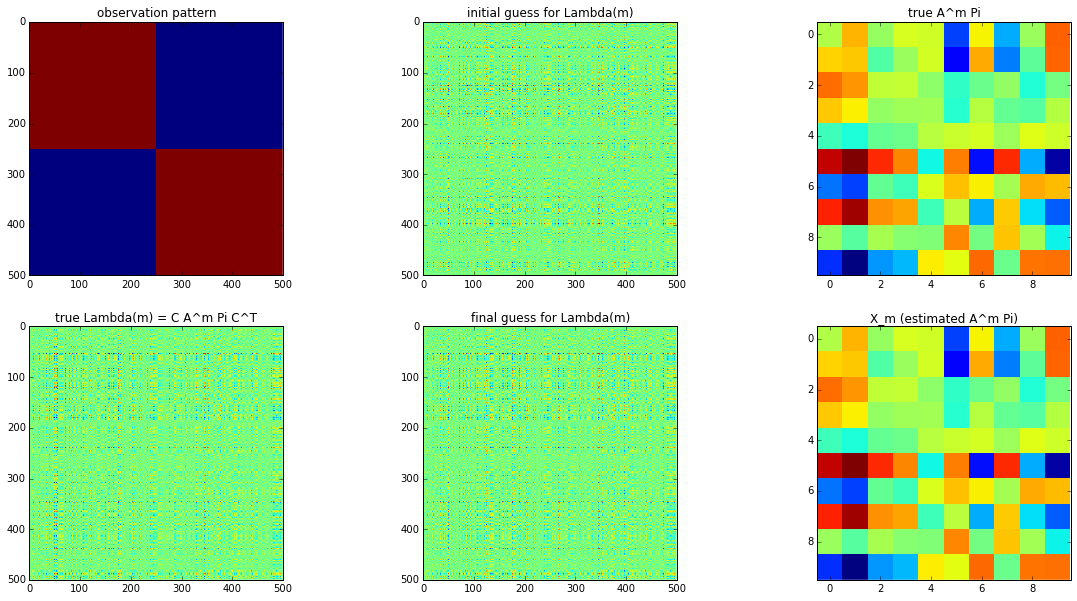

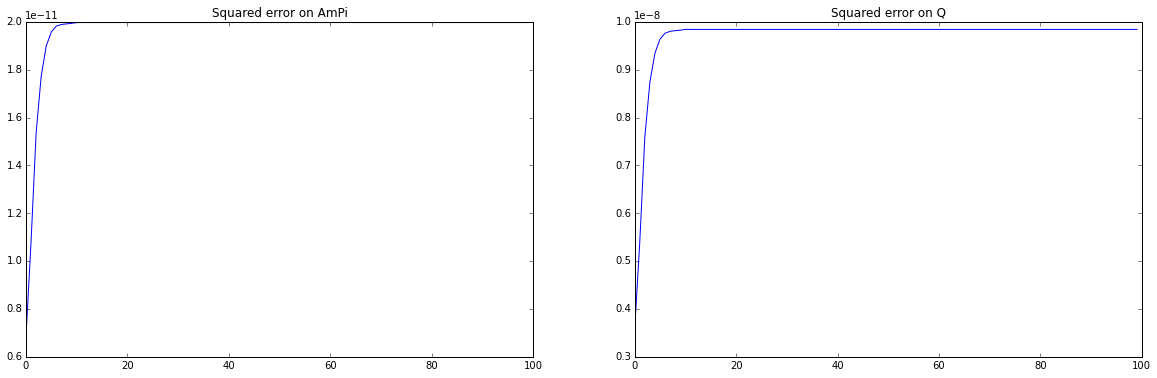


 Iterative variant, initialised from zero 
 
 
elapsed time:  0.13903474807739258
Visualising results for problem size (p,n) =  (500, 10)
Time lag is m =  2
Number of times we iterated the fixed-point equation:  100


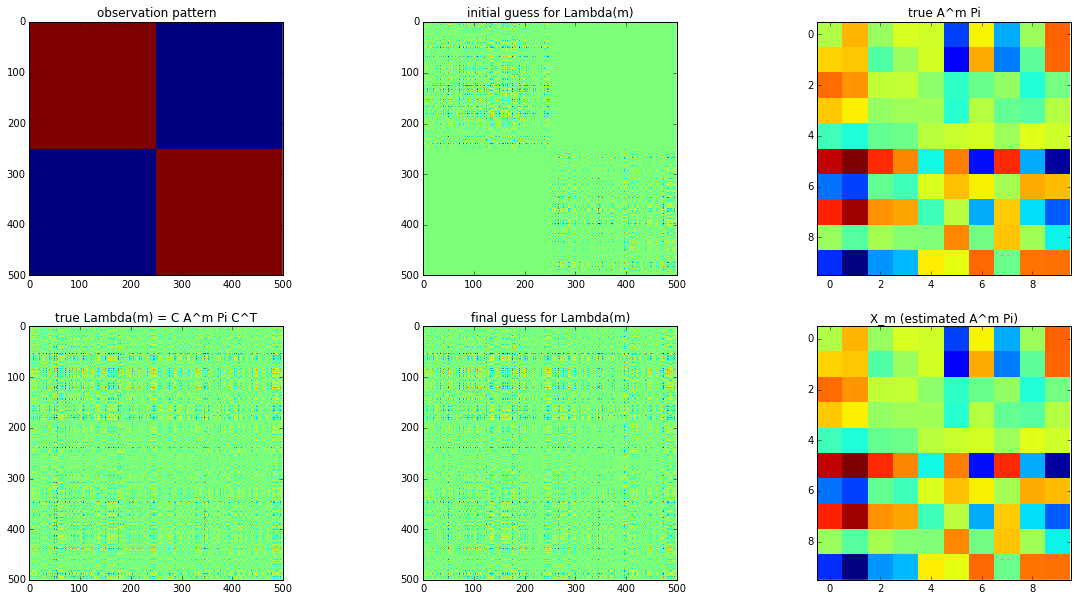

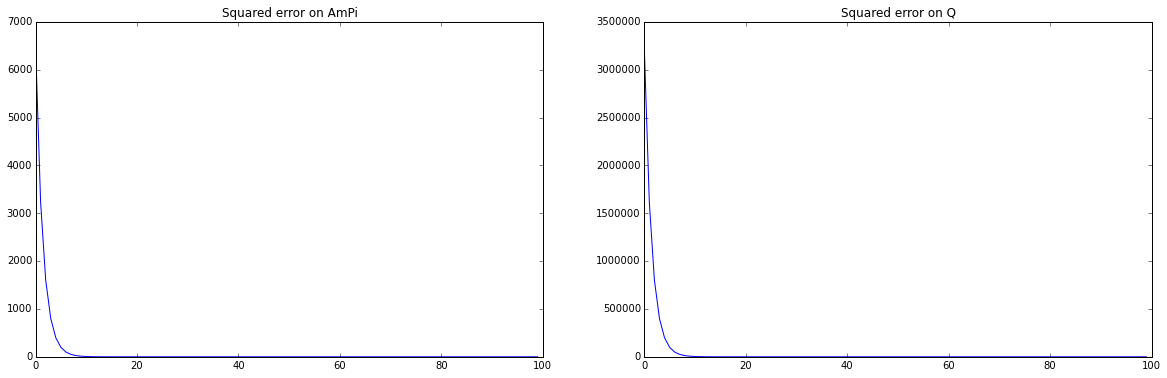

final MSE (starting from all zero) 4.06590358895e-24

 Analytic variant #2, computing from observed blocks 
 

elapsed time:  0.3011016845703125


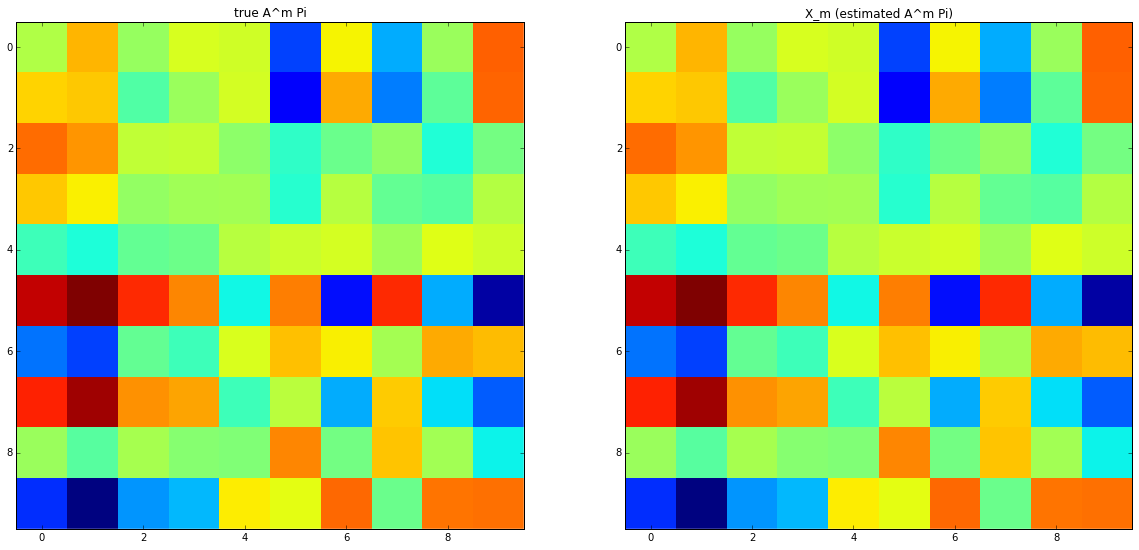

MSE 4.23995894031e-24


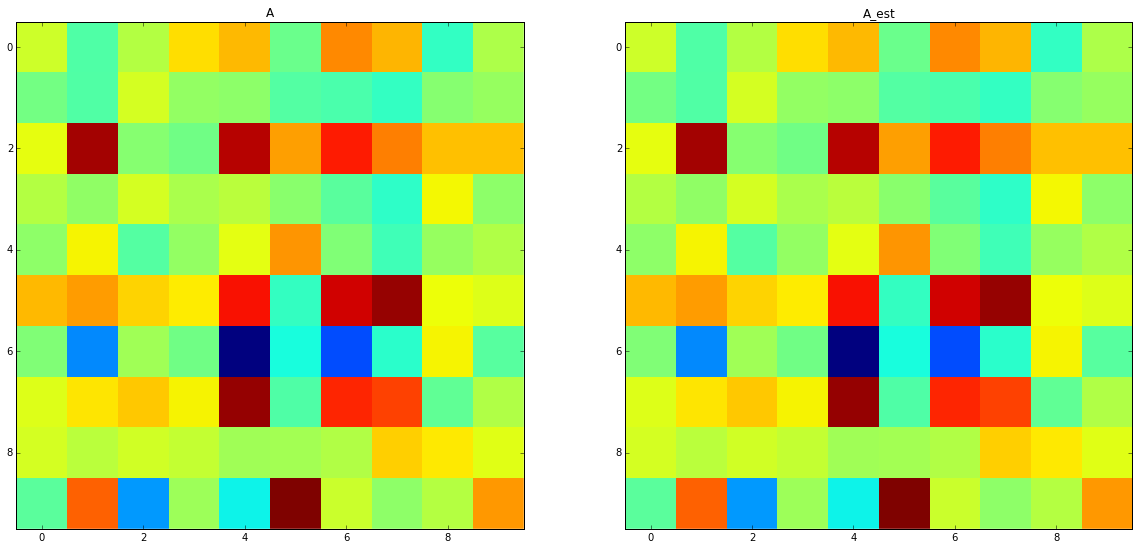

MSE 1.73267223483e-18
GC iteration # 0
GC iteration # 1
GC iteration # 2
GC iteration # 3
GC iteration # 4
GC iteration # 5
GC iteration # 6
GC iteration # 7
GC iteration # 8
GC iteration # 9
largest singular value:  6.19562638145
largest eigenvalue:  1.00515342266
GC iteration # 10
GC iteration # 11
GC iteration # 12
GC iteration # 13
GC iteration # 14
GC iteration # 15
GC iteration # 16
GC iteration # 17
GC iteration # 18
GC iteration # 19
largest singular value:  3.27590715391
largest eigenvalue:  1.15888674016
GC iteration # 20
GC iteration # 21
GC iteration # 22
GC iteration # 23
GC iteration # 24
GC iteration # 25
GC iteration # 26
GC iteration # 27
GC iteration # 28
GC iteration # 29
largest singular value:  2.24895985959
largest eigenvalue:  1.00502337922
GC iteration # 30
GC iteration # 31
GC iteration # 32
GC iteration # 33
GC iteration # 34
GC iteration # 35
GC iteration # 36
GC iteration # 37
GC iteration # 38
GC iteration # 39
largest singular value:  6.17185786474
largest

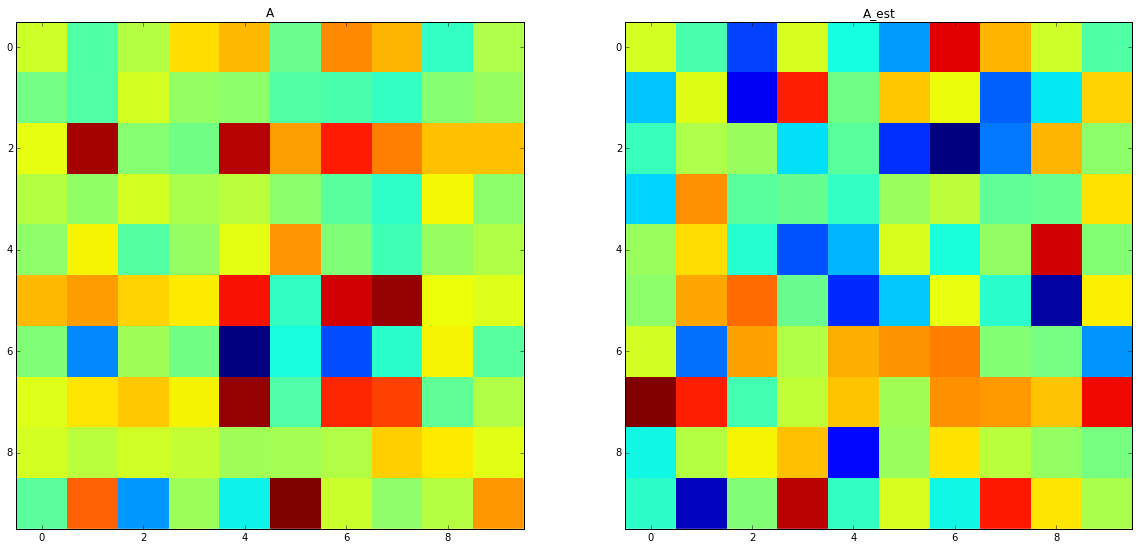

MSE 1.34117913428


In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from scipy.optimize import fmin_bfgs, check_grad
import glob, os
import time

os.chdir('../core')
from utility import get_subpop_stats, comp_model_covariances, gen_pars
from SSID_Hankel_loss import f_l2_Hankel, l2_sis_setup, g_l2_Hankel_sis, plot_outputs_l2_gradient_test
from SSID_Hankel_loss import yy_Hankel_cov_mat, l2_sis_draw, adam_zip, l2_coord_asc_setup, iter_X_m
os.chdir('../dev')


# pick problem size and time lag m
p, n, m = 500, 10, 2
nr = 2 # number of real eigenvalues for A

# pick number of fixed-point iterations
num_fixed_point_iters = 100

# create subpopulations
sub_pops = (np.arange(0,p//2), np.arange(p//2,p))
obs_idx, idx_grp, co_obs, overlaps, overlap_grp, idx_overlap, Om, Ovw, Ovc = \
    get_subpop_stats(sub_pops, p, verbose=False)
co_obs, not_co_obs = l2_coord_asc_setup(p,idx_grp,obs_idx)
not_Om = np.invert(Om)

# draw system parameters
ev_r = np.linspace(0.7, 1.005, nr)
ev_c = np.exp(2 * 1j * np.pi * np.random.uniform(size= (n - nr)//2))
ev_c = np.linspace(0.8, 1.005, (n - nr)//2) * ev_c
pars = gen_pars(p=p,n=n, nr=nr, ev_r = ev_r, ev_c = ev_c)
A_true, C_true, Pi_true = pars['A'], pars['C'], pars['Pi']

#C_true[0:p//4] = C_true[p//4:p//2].copy()
#C_true[p//2:3*p//4] = C_true[3*p//4:p].copy()

lam,V_est = np.linalg.eig(A_true)
AmPi = np.linalg.matrix_power(A_true,m).dot(Pi_true)
C = C_true.copy() #np.random.normal(size=(p,n))

# construct true, initial and estimate time-lagged covariance matrix Lambda(m)
Q_true = C.dot(AmPi).dot(C.T)




# run fixed-point interation, inintialised from largest subpopulation

d_est_n = np.zeros(num_fixed_point_iters)
d_est_p = np.zeros(num_fixed_point_iters)
Q_est = Q_true.copy()

i = 0 # pick first subpopulation
Cd_i = np.linalg.pinv(C[sub_pops[i],:])
X_m = Cd_i.dot(Q_true[np.ix_(sub_pops[i],sub_pops[i])]).dot(Cd_i.T)

Q_0 = Q_true.copy()
Q_0[not_Om] = C.dot(X_m).dot(C.T)[not_Om]

print('\n Iterative variant, initialised from largest subpop \n \n ')

t = time.time()

Cd = np.linalg.pinv(C)

if num_fixed_point_iters > 0:
    CdQCdT_obs = np.zeros((n,n))
    for idx in range(len(idx_grp)):
        a, b = idx_grp[idx], co_obs[idx]
        CdQCdT_obs += Cd[:,a].dot(Q_true[np.ix_(a, b)]).dot(Cd[:,b].T)
for iter_m in range(num_fixed_point_iters):
    d_est_n[iter_m] = np.sum((X_m - AmPi)**2)
    d_est_p[iter_m] = np.sum((Q_true - C.dot(X_m).dot(C.T))**2)
    X_m = iter_X_m(CdQCdT_obs,C,Cd,p,n,idx_grp,not_co_obs,X_m)   

print('elapsed time: ',  time.time() - t)
Q_est[not_Om] = C.dot(X_m).dot(C.T)[not_Om]
d_est_n, d_est_p = np.sqrt(d_est_n), np.sqrt(d_est_p)

print('Visualising results for problem size (p,n) = ', (p,n))
print('Time lag is m = ', m)
print('Number of times we iterated the fixed-point equation: ', num_fixed_point_iters)

plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
plt.imshow(Om, interpolation='none')
plt.title('observation pattern')
plt.subplot(2,3,4)
plt.imshow(Q_true, interpolation='none')
plt.title('true Lambda(m) = C A^m Pi C^T')
plt.subplot(2,3,2)
plt.imshow(Q_0, interpolation='none')
plt.title('initial guess for Lambda(m)')
plt.subplot(2,3,5)
plt.imshow(Q_est, interpolation='none')
plt.title('final guess for Lambda(m)')
plt.subplot(2,3,3)
plt.imshow(AmPi, interpolation='none')
plt.title('true A^m Pi')
plt.subplot(2,3,6)
plt.imshow(X_m, interpolation='none')
plt.title('X_m (estimated A^m Pi)')
plt.show()
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(d_est_n)
plt.title('Squared error on AmPi')
plt.subplot(1,2,2)
plt.plot(d_est_p)
plt.title('Squared error on Q')
plt.show()


# again, now initialise from zero


d_est_n = np.zeros(num_fixed_point_iters)
d_est_p = np.zeros(num_fixed_point_iters)
Q_est = Q_true.copy()

X_m = np.eye(n)
Q_0 = Q_true.copy()
Q_0[not_Om] = C.dot(X_m).dot(C.T)[not_Om]

print('\n Iterative variant, initialised from zero \n \n ')

t = time.time()

if num_fixed_point_iters > 0:
    CdQCdT_obs = np.zeros((n,n))
    for idx in range(len(idx_grp)):
        a, b = idx_grp[idx], co_obs[idx]
        CdQCdT_obs += Cd[:,a].dot(Q_true[np.ix_(a, b)]).dot(Cd[:,b].T)
for iter_m in range(num_fixed_point_iters):
    d_est_n[iter_m] = np.sum((X_m - AmPi)**2)
    d_est_p[iter_m] = np.sum((Q_true - C.dot(X_m).dot(C.T))**2)
    X_m = iter_X_m(CdQCdT_obs,C,Cd,p,n,idx_grp,not_co_obs,X_m)   

print('elapsed time: ',  time.time() - t)
Q_est[not_Om] = C.dot(X_m).dot(C.T)[not_Om]
d_est_n, d_est_p = np.sqrt(d_est_n), np.sqrt(d_est_p)

print('Visualising results for problem size (p,n) = ', (p,n))
print('Time lag is m = ', m)
print('Number of times we iterated the fixed-point equation: ', num_fixed_point_iters)

plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
plt.imshow(Om, interpolation='none')
plt.title('observation pattern')
plt.subplot(2,3,4)
plt.imshow(Q_true, interpolation='none')
plt.title('true Lambda(m) = C A^m Pi C^T')
plt.subplot(2,3,2)
plt.imshow(Q_0, interpolation='none')
plt.title('initial guess for Lambda(m)')
plt.subplot(2,3,5)
plt.imshow(Q_est, interpolation='none')
plt.title('final guess for Lambda(m)')
plt.subplot(2,3,3)
plt.imshow(AmPi, interpolation='none')
plt.title('true A^m Pi')
plt.subplot(2,3,6)
plt.imshow(X_m, interpolation='none')
plt.title('X_m (estimated A^m Pi)')
plt.show()
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(d_est_n)
plt.title('Squared error on AmPi')
plt.subplot(1,2,2)
plt.plot(d_est_p)
plt.title('Squared error on Q')
plt.show()

print('final MSE (starting from all zero)', np.mean( (AmPi - X_m)**2 ))

"""
##############################################################################
# Now use analytic solution (big system of linear equations)
##############################################################################

# variant 1, computes M of M*x + c from pseudo-transpose of C and non-observed blocks
print('\n Analytic variant #1, computing from non-observed blocks \n \n')

t = time.time()

M = np.zeros((n**2, n**2))
c = np.zeros((n**2, 1))
for i in range(len(idx_grp)):
    a,b,not_b = idx_grp[i], co_obs[i], np.setdiff1d(np.arange(p), co_obs[i])
    M += np.kron(Cd[:,a].dot(C[a,:]), Cd[:,not_b].dot(C[not_b,:]))
    c += np.kron(Cd[:,b],Cd[:,a]).dot(Q_true[np.ix_(a,b)].reshape(-1,1))
X = np.linalg.solve(np.eye(n**2) - M,c)

print('elapsed time: ',  time.time() - t)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(AmPi, interpolation='none')
plt.title('true A^m Pi')
plt.subplot(1,2,2)
plt.imshow(X[:,0].reshape(n,n), interpolation='none')
plt.title('X_m (estimated A^m Pi)')
plt.show()
print('MSE', np.mean( (AmPi - X.reshape(n,n))**2 ))
"""

##############################################################################
# Now use analytic solution (big system of linear equations)
##############################################################################
# variant 2, computes M of M*x + c from C and observed blocks
print('\n Analytic variant #2, computing from observed blocks \n \n')

k,l = n,n
del Q_true
Qs = comp_model_covariances({'A' : A_true, 'Pi' : Pi_true, 'C' : C_true}, k+l)

t = time.time()

M = np.zeros((n**2, n**2))
c = np.zeros((n**2, k+l-1))
for i in range(len(idx_grp)):
    a,b = idx_grp[i], co_obs[i]
    M += np.kron(C[a,:].T.dot(C[a,:]), C[b,:].T.dot(C[b,:]))
    Mab = np.kron(C[a,:], C[b,:])
    for m_ in range(1,k+l):
        c[:,m_-1] +=  Mab.T.dot(Qs[m_][np.ix_(a,b)].reshape(-1,))
X = np.linalg.solve(M,c)

print('elapsed time: ',  time.time() - t)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(AmPi, interpolation='none')
plt.title('true A^m Pi')
plt.subplot(1,2,2)
plt.imshow(X[:,m-1].reshape(n,n), interpolation='none')
plt.title('X_m (estimated A^m Pi)')
plt.show()
print('MSE', np.mean( (AmPi - X[:,m-1].reshape(n,n))**2 ))




import cvxopt

cvxopt.solvers.options['show_progress'] = False
X1,X2 = np.zeros((n, n*(k+l-2))), np.zeros((n, n*(k+l-2)))
for m in range(k+l-2):
    X1[:,(m)*n:(m+1)*n] = X[:,m].reshape(n,n)
    X2[:,(m)*n:(m+1)*n] = X[:,m+1].reshape(n,n)
    
P = cvxopt.matrix( np.kron(np.eye(n), X1.dot(X1.T)), tc='d')
q = cvxopt.matrix( - (X2.dot(X1.T)).reshape(n**2,), tc='d')


sol = cvxopt.solvers.qp(P=P,q=q)
assert sol['status'] == 'optimal'
A_ls = np.asarray(sol['x']).reshape(n,n)


plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(A_true, interpolation='none')
plt.title('A')
plt.subplot(1,2,2)
plt.imshow(A_ls, interpolation='none')
plt.title('A_est')
plt.show()


print('MSE', np.mean( (A_true - A_ls)**2 ))

_,s,_ = np.linalg.svd(A_ls)
lam = np.linalg.eigvals(A_ls)
s[0], lam[0]

################################################################
# And now: STABLE
################################################################

X1,X2 = np.zeros((n, n*(k+l-2))), np.zeros((n, n*(k+l-2)))
for m in range(k+l-2):
    X1[:,(m)*n:(m+1)*n] = X[:,m].reshape(n,n)
    X2[:,(m)*n:(m+1)*n] = X[:,m+1].reshape(n,n)
    
P = cvxopt.matrix( np.kron(np.eye(n), X1.dot(X1.T)), tc='d')
q = cvxopt.matrix( - (X2.dot(X1.T)).reshape(n**2,), tc='d')


lam0 = np.inf

h = np.array([]).reshape(0,)
G = np.zeros((0,n**2))

def mat(X):
    return cvxopt.matrix(X, tc='d')

while lam0 > 1. and G.shape[0] < 1000:

    initvals = {'x' : sol['x']}
    #initvals = {}
    
    print('GC iteration #', G.shape[0])
    
    sol = cvxopt.solvers.qp(P=P,q=q,G=mat(G),h=mat(h),initvals=initvals)

    assert sol['status'] == 'optimal'
    A_sls = np.asarray(sol['x']).reshape(n,n)

    lam0 = np.max(np.abs(np.linalg.eigvals(A_sls)))    
    U,s,V = np.linalg.svd(A_sls)
    g = np.outer( U[:,0], V[0,:] ).reshape(n**2,)
    G = np.vstack((G,np.atleast_2d(g)))
    h = np.ones(G.shape[0])
    if np.mod(G.shape[0],10) == 0:
        print('largest singular value: ' , s[0])
        print('largest eigenvalue: ' , lam0)
    

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(A_true, interpolation='none')
plt.title('A')
plt.subplot(1,2,2)
plt.imshow(A_sls, interpolation='none')
plt.title('A_est')
plt.show()


print('MSE', np.mean( (A_true - A_sls)**2 ))



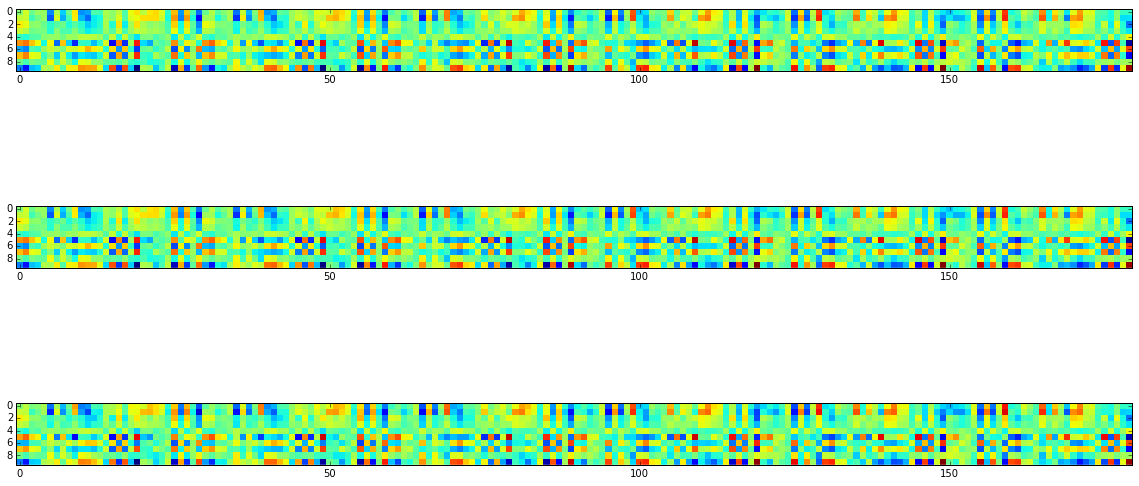

In [22]:
plt.figure(figsize=(20,10))
plt.subplot(3,1,1)
plt.imshow(A_ls.dot(X1), interpolation='none')
plt.subplot(3,1,2)
plt.imshow(X2, interpolation='none')
plt.subplot(3,1,3)
plt.imshow(A_sls.dot(X1), interpolation='none')
plt.show()

In [ ]:
cvxopt.solvers.qp?

In [ ]:
G.dot(A_sls.reshape(-1,))

In [ ]:
U,s,V = np.linalg.svd(A_est)
U[:,0].dot(A_est.dot(V[0,:]))

np.outer(U[:,0], V[0,:]).T.reshape(-1,).dot(A_est.T.reshape(-1,))



**Showcasing full gradient descent along $C$ with $A^m \Pi$ computed at each gradient step**

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from scipy.optimize import fmin_bfgs, check_grad
import glob, os

os.chdir('../core')
import stitching_ssid as ssid
os.chdir('../dev')

import pprint

p,n = 1000,50
k,l = 5,5
max_iter = 10000  # maximum number of gradient steps
max_iter_X_m = 5 # maximum number of iterations for fixed-point iteration
nr = 6 # number of real eigenvalues for A (rest will be complex)


# create subpopulations
sub_pops = (np.arange(0,p//2+1), np.arange(p//2-1,p))
obs_idx, idx_grp, co_obs, overlaps, overlap_grp, idx_overlap, Om, Ovw, Ovc = \
    ssid.get_subpop_stats(sub_pops, p, verbose=True)
co_obs, not_co_obs = ssid.l2_coord_asc_fast_setup(p,idx_grp,obs_idx)
not_Om = np.invert(Om)

idx_init = sub_pops[0]     

for rep in range(1):
    
# generate model and data
    """
    # draw system parameters
    ev_r = np.linspace(0.7, 0.9, nr)
    ev_c = np.exp(2 * 1j * np.pi * np.random.uniform(size= (n - nr)//2))
    ev_c = np.linspace(0.8, 0.9, (n - nr)//2) * ev_c
    pars = ssid.gen_pars(p=p,n=n, nr=nr, ev_r = ev_r, ev_c = ev_c)
    A, C_true, Pi = pars['A'], pars['C'], pars['Pi']
    
    # compute infinite-date covariance matrices
    Qs, Qs_full = [], []
    for kl_ in range(0,k+l):
        Akl = np.linalg.matrix_power(A, kl_)
        Qs.append(C_true.dot(Akl.dot(Pi)).dot(C_true.T) *np.asarray( Om,dtype=int) )
        Qs_full.append(C_true.dot(Akl.dot(Pi)).dot(C_true.T) )      
        
    H_true = ssid.yy_Hankel_cov_mat_coord_asc_fast(C_true,Qs_full,k,l,np.ones((p,p),dtype=bool),idx_grp, 
        co_obs, not_co_obs, max_iter=max_iter_X_m, idx_init = idx_init)        
    H_emp = ssid.yy_Hankel_cov_mat_coord_asc_fast(C_true,Qs_full,k,l,Om,idx_grp, co_obs, not_co_obs, 
        max_iter=max_iter_X_m, idx_init = idx_init)
    H_emp[np.where(H_emp==0)] = np.nan
        
    # initialise the model
    C_0 = np.random.normal(size=(p,n))        
    H_init = ssid.yy_Hankel_cov_mat_coord_asc_fast(C_0,Qs_full,k,l,np.ones((p,p),dtype=bool),idx_grp, co_obs, not_co_obs, 
            max_iter=max_iter_X_m, idx_init = idx_init)
        
    C_est = C_0.copy().reshape(p*n,)

    # fit the model
    def f_i(C):        
        #return ssid.f_l2_Hankel_coord_asc(C, k, l, n, Qs, Om, not_Om, max_iter=max_iter_X_m, idx_init=idx_init)
        return ssid.f_l2_Hankel_coord_asc_fast(C, Qs, k, l, n, Om, idx_grp,co_obs,not_co_obs,
            max_iter=max_iter_X_m, idx_init = max_iter_X_m)
    
    def g_i(C):
        #return ssid.g_l2_coord_asc(C,k,l,n,Qs,not_Om,max_iter=max_iter_X_m, idx_init=idx_init)  
        return ssid.g_l2_coord_asc_fast(C, Qs, k,l,n, idx_grp,co_obs,not_co_obs, 
            max_iter=max_iter_X_m, idx_init=idx_init)
    
    #C_est = fmin_bfgs(f_i, C_0.reshape(p*n,), fprime=g_i, gtol=1e-5).reshape(p,n)    
    """
    
    C_est = C_est.reshape(p*n,)
    alpha = 0.00000001
    for i in range(max_iter):
        
        # reduce step size along the way
        #if np.mod(i, max_iter//2) == 0:
        #    alpha *= 0.8
            
        if False: #np.mod(i,max_iter//2)==0:
            C_est = C_est.reshape(p,n)        
            H_est = ssid.yy_Hankel_cov_mat_coord_asc_fast(C_est,Qs_full,k,l,np.ones((p,p),dtype=bool),idx_grp, co_obs, not_co_obs, 
                    max_iter=max_iter_X_m, idx_init = idx_init)

            H_obs = ssid.yy_Hankel_cov_mat_coord_asc_fast(C_est,Qs_full,k,l,Om,idx_grp, co_obs, not_co_obs, 
                    max_iter=max_iter_X_m, idx_init = idx_init)
            H_obs[np.where(H_obs==0)] = np.nan

            plt.figure(figsize=(20,9))
            plt.subplot(1,2,1)
            plt.plot(H_true[np.isnan(H_emp)], H_est[np.isnan(H_obs)], 'k.')
            plt.xlabel('true un-observed covariances(all time lags)')
            plt.ylabel('est. stitchted covariances(all time lags)')
            plt.subplot(1,2,2)
            plt.plot(H_true[np.invert(np.isnan(H_emp))], H_est[np.invert(np.isnan(H_obs))], 'k.')
            plt.xlabel('true observed covariances(all time lags)')
            plt.ylabel('est. observed covariances(all time lags)')
            plt.show()
            
            plt.figure(figsize=(20,4))
            plt.plot(C_est.reshape(p*n,))
            plt.show()
            C_est = C_est.reshape(p*n,)
        
                
        C_est -= alpha * g_i(C_est)
        
    C_est = C_est.reshape(p,n)


    # evaluate results
    print('initial squared error on observed parts:', 
          #ssid.f_l2_Hankel_coord_asc(C_0,k,l,n,Qs, Om, not_Om, max_iter=max_iter_X_m, idx_init=idx_init))    
          ssid.f_l2_Hankel_coord_asc_fast(C_0, Qs_full, k, l, n, Om, idx_grp,co_obs,not_co_obs,
            max_iter=max_iter_X_m, idx_init = idx_init))
        
    """
    print('initial squared error on stitched parts:', 
          f_l2_Hankel(C_0,k,l,n,Qs,not_Om))    
    print('final squared error on overlapping parts:', 
          f_l2_Hankel(C_est,k,l,n,Qs,Ovw))
    print('final squared error on cross-overlapping parts:',
          f_l2_Hankel(C_est,k,l,n,Qs,Ovc))
    print('final squared error on stitched parts:',
          f_l2_Hankel(C_est,k,l,n,Qs_full,~Om))
    """
    print('\n final squared error on observed parts:', 
          #ssid.f_l2_Hankel_coord_asc(C_est,k,l,n,Qs, Om, not_Om, max_iter=max_iter_X_m, idx_init=idx_init))
          ssid.f_l2_Hankel_coord_asc_fast(C_est, Qs_full, k, l, n, Om, idx_grp,co_obs,not_co_obs,
            max_iter=max_iter_X_m, idx_init = idx_init))

    H_est = ssid.yy_Hankel_cov_mat_coord_asc_fast(C_est,Qs_full,k,l,np.ones((p,p),dtype=bool),idx_grp, co_obs, not_co_obs, 
            max_iter=max_iter_X_m, idx_init = idx_init)

    H_obs = ssid.yy_Hankel_cov_mat_coord_asc_fast(C_est,Qs_full,k,l,Om,idx_grp, co_obs, not_co_obs, 
            max_iter=max_iter_X_m, idx_init = idx_init)
    H_obs[np.where(H_obs==0)] = np.nan

    plt.figure(figsize=(20,9))
    plt.subplot(1,2,1)
    plt.plot(H_true[np.isnan(H_emp)], H_est[np.isnan(H_obs)], 'k.')
    plt.xlabel('true un-observed covariances(all time lags)')
    plt.ylabel('est. stitchted covariances(all time lags)')
    plt.subplot(1,2,2)
    plt.plot(H_emp, H_obs, 'k.')
    plt.xlabel('true observed covariances(all time lags)')
    plt.ylabel('est. observed covariances(all time lags)')
    plt.show()
    
    if p < 101:
        nrows,ncols,figsize = (2,2,(20,16))
        plt.figure(figsize=figsize)
        plt.subplot(nrows,ncols,1)
        plt.imshow(H_obs,interpolation='none')
        plt.title('Given data matrix (C_true, masked)')
        plt.subplot(nrows,ncols,2)
        plt.imshow(H_true,interpolation='none')
        plt.title('True  matrix (C_true)')    
        plt.subplot(nrows,ncols,3)
        plt.imshow(H_init,interpolation='none')
        plt.title('Initial matrix (C_0)')
        plt.subplot(nrows,ncols,4)
        plt.imshow(H_est,interpolation='none')
        plt.title('Estimated matrix (C_est)')
        plt.show()  

    
    

# Stochastic gradient

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from scipy.optimize import fmin_bfgs, check_grad
import glob, os

N = 100;
#def f_i(theta):
#    return ((theta-500)**4).sum()
#def g_i(theta):
#    return 4*(theta -500)**3

max_iter = 100
def converged(theta_old, theta, e, t):
    return t >= max_iter

def adam(f_i,g_i,theta_0,a,b1,b2,e,converged):
    
    t, m, v = 0, np.zeros(N), np.zeros(N)
    theta, theta_old = theta_0.copy(), np.inf * np.ones(N)

    res, fun = np.empty((max_iter, N)), np.empty(max_iter)    
    while not converged(theta_old, theta, e, t):

        t += 1
        theta_old = theta.copy()

        g = g_i(theta_old)
        m = (b1 * m + (1-b1)* g)     
        v = (b2 * v + (1-b2)*(g**2)) 
        mh = m / (1-b1**t)
        vh = v / (1-b2**t)
        theta = theta_old - a * mh/(np.sqrt(vh) + e)
        res[t-1,:] = theta.copy()
        fun[t-1] = f_i(theta)
    return res, fun


# classical first-order descent
a, b1, b2, e = 10, 0.0, 0.0, 10e-8
theta_0 = np.zeros(N)
res,fun = adam(f_i,g_i,theta_0,a,b1,b2,e,converged)
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(fun, 'k')
plt.subplot(1,2,2)
plt.plot(res, 'k')
print(fun[0], fun[-1])

# giving momentum
a, b1, b2, e = 0.01, 0.3, 0.0, 10e-8
theta_0 = np.zeros(N)
res,fun = adam(f_i,g_i,theta_0,a,b1,b2,e,converged)
plt.subplot(1,2,1)
plt.plot(fun, 'r')
plt.subplot(1,2,2)
plt.plot(res, 'r')
print(fun[0], fun[-1])

# giving second-order momentum
a, b1, b2, e = 10, 0.9, 0.999, 1e-8
theta_0 = 0*np.ones(N)
res,fun = adam(f_i,g_i,theta_0,a,b1,b2,e,converged)
plt.subplot(1,2,1)
plt.plot(fun, 'g')
plt.subplot(1,2,2)
plt.plot(res, 'g')
plt.show()
print(fun[0], fun[-1])



# Debug and unfinished stuff

In [ ]:
def collect_constraints(H, Ov, k, l, ovl_size):

    p = Om.shape[0]    
    assert Om.shape[1] == p and H.shape == (k*p, l*p)

    n_cnstr = np.sum(Ov)
    cnstr = 42 * np.ones(k*l*n_cnstr)


    for k_ in range(k):
        offset_k = k_*k*n_cnstr
        for l_ in range(l):
            cnstr[offset_k+l_*n_cnstr:offset_k+(l_+1)*n_cnstr] = H[k_*p:(k_+1)*p, l_*p:(l_+1)*p][Ov]

    return cnstr.reshape(-1,ovl_size)

ovl_size = 1
H = ssid.yy_Hankel_cov_mat(C_true,A,Pi,k,l)
x = collect_constraints(H, Ovw, k, l, ovl_size)
plt.imshow(x.reshape(k,l), interpolation='none')   
m,M = np.min(x), np.max(x)

plt.figure(figsize=(20,10))
for k_ in range(k):
    for l_ in range(l):
        plt.subplot(k,l,(k_*k)+l_)
        plt.imshow( x[ovl_size*(k_*k+l_):ovl_size*(k_*k+l_+1),:], interpolation='none', vmin=m, vmax=M)
        plt.title(str(x[ovl_size*(k_*k+l_):ovl_size*(k_*k+l_+1),:][0,0]))
plt.show()

tmp = x.reshape(k,l)
_,s,_ = np.linalg.svd(tmp)
print(s)

_,s,_ = np.linalg.svd(ssid.observability_mat({'A': A, 'C': C_true[3,:]},k))
print(s)

ssid.observability_mat({'A': A, 'C': C_true[3,:]},k)
